In [2]:
import numpy as np
import pandas as pd
import os

# Load data
seed = 0
run = 0
intervention = 'none'

path = os.getcwd() + '/Data/Model_V1/Data/'

data_gem = pd.read_pickle(path + 'Gemeenten.pkl')
data_gem_id = pd.read_pickle(path +'GemeentenID.pkl')
data_pos = np.load(path + 'Positions.npy')

path = os.getcwd() + '/Data/Model_V1/Data/High/Seed_' + str(seed) + '/'

data_people = pd.read_pickle(path + 'PeopleDF.pkl')

data_phases = pd.read_pickle(path + 'Runs_' + intervention + '/Phases_' + str(run) + '.pkl')
data_status = np.load(path + 'Runs_' + intervention + '/Status_' + str(run) + '.npz')
data_timestep = np.loadtxt(path + 'Runs_' + intervention + '/Timestep_' + str(run))

# Data info
print('gem: ', data_gem.shape)
print('gem_id: ', data_gem_id.shape)
print('pos: ',data_pos.shape)
print('people: ',data_people.shape)
print(data_status.files)

# timesteps: n_days * 24
print('timesteps: ', data_status['indptr'].shape)
print('status: ', data_status['data'].shape)

gem:  (380, 1)
gem_id:  (380, 1)
pos:  (7, 24, 170721)
people:  (170721, 382)
['indices', 'indptr', 'format', 'shape', 'data']
timesteps:  (2881,)
status:  (148303577,)


In [3]:
# Compute infected cases per timestep
timesteps = data_status['indptr'].shape[0] -1
data = data_status['data']
indptr = data_status['indptr']

exposed = []
infected = []
recovered = []
for t in range(0, timesteps):
    timestamp_row = data[indptr[t] : indptr[t + 1]]
    exposed_count = np.count_nonzero(timestamp_row == 1)
    exposed.append(exposed_count)
    infected_count = np.count_nonzero(timestamp_row == 2)
    infected.append(infected_count)
    recovered_count = np.count_nonzero(timestamp_row == 3)
    recovered.append(recovered_count)

# Minimum at 107
print(np.argmin(infected))

    

107


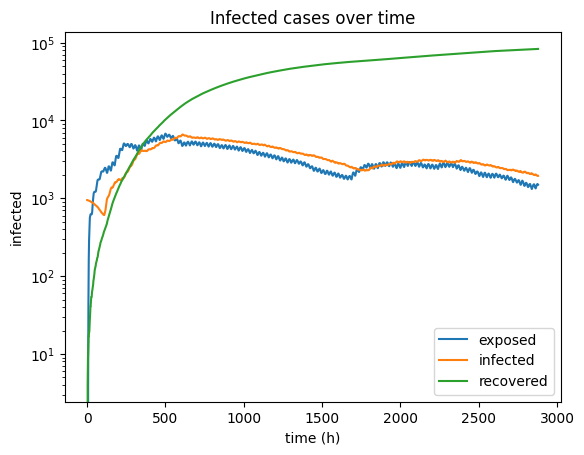

In [4]:
import matplotlib.pyplot as plt

plt.title('Infected cases over time')
plt.xlabel('time (h)')
plt.ylabel('infected')
plt.yscale('log')
plt.plot(np.arange(0, timesteps), exposed, label='exposed')
plt.plot(np.arange(0, timesteps), infected, label='infected')
plt.plot(np.arange(0, timesteps), recovered, label='recovered')
plt.legend()
plt.show()